# Modeling Your Data - Lab

## Introduction 

In this lab you'll perform a full linear regression analysis on the data. You'll implement the process demonstrated in the previous lesson, taking a stepwise approach to analyze and improve the model along the way.

## Objectives
You will be able to:

* Perform a full linear regression with iterations based on p-value of features and other parameters
* Create visualizations to better understand the distributions of variables in a dataset
* Determine whether or not the assumptions for linear regression hold true for this example

## Build an Initial Regression Model

To start, perform a train-test split and create an initial regression model to model the `list_price` using all of your available features.

> **Note:** In order to write the model you'll have to do some tedious manipulation of your column names. Statsmodels will not allow you to have spaces, apostrophe or arithmetic symbols (+) in your column names. Preview them and refine them as you go.  
**If you receive an error such as "PatsyError: error tokenizing input (maybe an unclosed string?)", then you need to further preprocess your column names.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('Lego_dataset_cleaned.csv')
df.head()

piece_count  list_price  num_reviews  play_star_rating  star_rating  \
0    -0.273020       29.99    -0.398512         -0.655279    -0.045687   
1    -0.404154       19.99    -0.398512         -0.655279     0.990651   
2    -0.517242       12.99    -0.147162         -0.132473    -0.460222   
3     0.635296       99.99     0.187972         -1.352353     0.161581   
4     0.288812       79.99    -0.063378         -2.049427     0.161581   

   val_star_rating  ages_10+  ages_10-14  ages_10-16  ages_10-21  ...  \
0        -0.365010         0           0           0           0  ...   
1        -0.365010         0           0           0           0  ...   
2        -0.204063         0           0           0           0  ...   
3         0.117830         0           0           0           0  ...   
4        -0.204063         0           0           0           0  ...   

   country_NZ  country_PL  country_PT  country_US  review_difficulty_Average  \
0           0           0           0           1                          1   
1           0           0           0           1                          0   
2           0           0           0           1                          0   
3           0           0           0           1                          1   
4           0           0           0           1                          0   

   review_difficulty_Challenging  review_difficulty_Easy  \
0                              0                       0   
1                              0                       1   
2                              0                       1   
3                              0                       0   
4                              1                       0   

   review_difficulty_Very Challenging  review_difficulty_Very Easy  \
0                                   0                            0   
1                                   0                            0   
2                                   0                            0   
3                                   0                            0   
4                                   0                            0   

   review_difficulty_unknown  
0                          0  
1                          0  
2                          0  
3                          0  
4                          0  

[5 rows x 103 columns]

In [3]:
subs = [(' ', '_'),('.',''),("'",""),('™', ''), ('®',''),
        ('+','plus'), ('½','half'), ('-','_')
       ]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

In [4]:
df.columns = [col_formatting(col) for col in df.columns]

In [5]:
list(df.columns)

['piece_count',
 'list_price',
 'num_reviews',
 'play_star_rating',
 'star_rating',
 'val_star_rating',
 'ages_10plus',
 'ages_10_14',
 'ages_10_16',
 'ages_10_21',
 'ages_11_16',
 'ages_12plus',
 'ages_12_16',
 'ages_14plus',
 'ages_16plus',
 'ages_1half_3',
 'ages_1half_5',
 'ages_2_5',
 'ages_4plus',
 'ages_4_7',
 'ages_4_99',
 'ages_5plus',
 'ages_5_12',
 'ages_5_8',
 'ages_6plus',
 'ages_6_12',
 'ages_6_14',
 'ages_7plus',
 'ages_7_12',
 'ages_7_14',
 'ages_8plus',
 'ages_8_12',
 'ages_8_14',
 'ages_9plus',
 'ages_9_12',
 'ages_9_14',
 'ages_9_16',
 'theme_name_Angry_Birds',
 'theme_name_Architecture',
 'theme_name_BOOST',
 'theme_name_Blues_Helicopter_Pursuit',
 'theme_name_BrickHeadz',
 'theme_name_Carnotaurus_Gyrosphere_Escape',
 'theme_name_City',
 'theme_name_Classic',
 'theme_name_Creator_3_in_1',
 'theme_name_Creator_Expert',
 'theme_name_DC_Comics_Super_Heroes',
 'theme_name_DC_Super_Hero_Girls',
 'theme_name_DIMENSIONS',
 'theme_name_DUPLO',
 'theme_name_Dilophosaurus_Out

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10870 entries, 0 to 10869
Columns: 103 entries, piece_count to review_difficulty_unknown
dtypes: float64(6), int64(97)
memory usage: 8.5 MB


In [7]:
# Defining the problem
outcome = 'list_price'
x_cols = list(df.columns)
x_cols.remove(outcome)

In [8]:
train, test = train_test_split(df)

In [9]:
print(len(train), len(test))
train.head()

8152 2718


piece_count  list_price  num_reviews  play_star_rating  star_rating  \
9322      1.049150    182.9878     0.467250         -0.481010    -0.252954   
4617     -0.481150     15.6000    -0.426440          1.087407     0.990651   
4780      0.054214     65.8800    -0.342657          0.564601     0.576116   
10609     0.441602    121.9878    -0.342657          1.087407     0.576116   
2225      1.352323    195.1878     0.104189         -1.526621    -1.496559   

       val_star_rating  ages_10plus  ages_10_14  ages_10_16  ages_10_21  ...  \
9322         -0.525957            0           0           0           0  ...   
4617          1.244458            0           0           0           0  ...   
4780          0.117830            0           0           0           0  ...   
10609        -0.365010            0           0           0           0  ...   
2225         -1.491638            0           0           0           0  ...   

       country_NZ  country_PL  country_PT  country_US  \
9322            0           0           0           0   
4617            0           0           0           0   
4780            0           0           0           0   
10609           0           0           1           0   
2225            0           0           0           0   

       review_difficulty_Average  review_difficulty_Challenging  \
9322                           0                              1   
4617                           1                              0   
4780                           0                              0   
10609                          1                              0   
2225                           1                              0   

       review_difficulty_Easy  review_difficulty_Very_Challenging  \
9322                        0                                   0   
4617                        0                                   0   
4780                        1                                   0   
10609                       0                                   0   
2225                        0                                   0   

       review_difficulty_Very_Easy  review_difficulty_unknown  
9322                             0                          0  
4617                             0                          0  
4780                             0                          0  
10609                            0                          0  
2225                             0                          0  

[5 rows x 103 columns]

In [10]:
test.head()

piece_count  list_price  num_reviews  play_star_rating  star_rating  \
2331    -0.518445     10.1322    -0.286801          0.216064     0.161581   
6118    -0.572583     36.5878    -0.370585         -0.132473    -0.460222   
3444    -0.167150     25.3980    -0.175090          0.390333     0.576116   
8020    -0.540100      6.0878    -0.342657         -0.132473    -0.045687   
2334    -0.512430     10.1322    -0.426440         -0.655279     0.990651   

      val_star_rating  ages_10plus  ages_10_14  ages_10_16  ages_10_21  ...  \
2331         0.117830            0           0           0           0  ...   
6118        -1.491638            0           0           0           0  ...   
3444         0.600671            0           0           0           0  ...   
8020         0.117830            0           0           0           0  ...   
2334        -0.365010            0           0           0           0  ...   

      country_NZ  country_PL  country_PT  country_US  \
2331           0           0           0           0   
6118           0           0           0           0   
3444           0           0           0           0   
8020           0           0           0           0   
2334           0           0           0           0   

      review_difficulty_Average  review_difficulty_Challenging  \
2331                          0                              0   
6118                          1                              0   
3444                          0                              0   
8020                          1                              0   
2334                          0                              0   

      review_difficulty_Easy  review_difficulty_Very_Challenging  \
2331                       0                                   0   
6118                       0                                   0   
3444                       1                                   0   
8020                       0                                   0   
2334                       1                                   0   

      review_difficulty_Very_Easy  review_difficulty_unknown  
2331                            0                          1  
6118                            0                          0  
3444                            0                          0  
8020                            0                          0  
2334                            0                          0  

[5 rows x 103 columns]

In [11]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     535.2
Date:                Mon, 30 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:52:25   Log-Likelihood:                -40631.
No. Observations:                8152   AIC:                         8.145e+04
Df Residuals:                    8057   BIC:                         8.212e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           64.8612      1.744     37.193      0.000      61.443      68.280
piece_count                                         74.9476      0.901     83.162      0.000      73.181      76.714
num_reviews                                          6.9764      0.705      9.893      0.000       5.594       8.359
play_star_rating                                     4.9752      0.632      7.878      0.000       3.737       6.213
star_rating                                         -1.5662      0.718     -2.180      0.029      -2.975      -0.158
val_star_rating                                     -8.1746      0.639    -12.793      0.000      -9.427      -6.922
ages_10plus                                        132.5639      6.698     19.792      0.000     119.434     145.693
ages_10_14                                         -25.7403      9.294     -2.770      0.006     -43.959      -7.522
ages_10_16                                         -13.6084      4.121     -3.302      0.001     -21.687      -5.530
ages_10_21                                          52.6182      7.379      7.130      0.000      38.153      67.084
ages_11_16                                         -25.1561      5.759     -4.369      0.000     -36.444     -13.868
ages_12plus                                         73.1912      5.653     12.948      0.000      62.111      84.272
ages_12_16                                         -54.3087      6.629     -8.193      0.000     -67.303     -41.314
ages_14plus                                         19.7380      4.250      4.644      0.000      11.406      28.070
ages_16plus                                         38.0731      6.050      6.294      0.000      26.214      49.932
ages_1half_3                                        -9.1021      2.488     -3.658      0.000     -13.979      -4.225
ages_1half_5                                        -3.4366      3.126     -1.099      0.272      -9.564       2.691
ages_2_5                                            14.7228      1.717      8.575      0.000      11.357      18.089
ages_4plus                                         -20.1622      6.412     -3.145      0.002     -32.731      -7.594
ages_4_7                                            -5.3924      3.801     -1.419      0.156     -12.844       2.059
ages_4_99                                           -1.8210      3.661     -0.497      0.619      -8.997       5.355
ages_5plus                                          -9.1452      3.355     -2.726      0.006     -15.721      -2.569
ages_5_12                                          -36.1423      3.183    -11.353      0.000     -42.383     -29.902
ages_5_8                                 

## Remove the Uninfluential Features

Based on the initial model, remove those features which do not appear to be statistically relevant and rerun the model.

In [12]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

103 72
['piece_count', 'num_reviews', 'play_star_rating', 'star_rating', 'val_star_rating']


0                       coef    std err          t  P>|t|     [0.025  \
                                                                       
Intercept            64.8612      1.744     37.193  0.000     61.443   
piece_count          74.9476      0.901     83.162  0.000     73.181   
num_reviews           6.9764      0.705      9.893  0.000      5.594   
play_star_rating      4.9752      0.632      7.878  0.000      3.737   
star_rating          -1.5662      0.718     -2.180  0.029     -2.975   

0                    0.975]  
                             
Intercept            68.280  
piece_count          76.714  
num_reviews           8.359  
play_star_rating      6.213  
star_rating          -0.158

In [13]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     708.8
Date:                Mon, 30 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:52:36   Log-Likelihood:                -40640.
No. Observations:                8152   AIC:                         8.142e+04
Df Residuals:                    8080   BIC:                         8.193e+04
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           63.1235      1.601     39.436      0.000      59.986      66.261
piece_count                                         75.1642      0.882     85.253      0.000      73.436      76.892
num_reviews                                          6.9132      0.693      9.973      0.000       5.554       8.272
play_star_rating                                     5.0413      0.615      8.203      0.000       3.837       6.246
star_rating                                         -1.4870      0.701     -2.121      0.034      -2.861      -0.113
val_star_rating                                     -8.1112      0.604    -13.439      0.000      -9.294      -6.928
ages_10plus                                        130.0601      4.841     26.864      0.000     120.570     139.550
ages_10_14                                         -19.5287      9.665     -2.021      0.043     -38.475      -0.583
ages_10_16                                          -7.6978      3.907     -1.970      0.049     -15.357      -0.039
ages_10_21                                          47.2955      3.271     14.461      0.000      40.884      53.707
ages_11_16                                         -19.4170      5.568     -3.488      0.000     -30.331      -8.503
ages_12plus                                         75.5952      6.183     12.227      0.000      63.475      87.715
ages_12_16                                         -48.4587      6.993     -6.930      0.000     -62.166     -34.752
ages_14plus                                         25.0545      4.907      5.105      0.000      15.435      34.674
ages_16plus                                         42.6640      6.791      6.283      0.000      29.352      55.976
ages_1half_3                                        -2.4120      3.197     -0.755      0.451      -8.678       3.854
ages_2_5                                            21.1856      2.002     10.585      0.000      17.262      25.109
ages_4plus                                         -18.8947      9.806     -1.927      0.054     -38.117       0.327
ages_5plus                                          -7.5176      3.322     -2.263      0.024     -14.029      -1.006
ages_5_12                                          -29.6111      2.734    -10.830      0.000     -34.971     -24.252
ages_6plus                                         -20.2238      6.093     -3.319      0.001     -32.168      -8.280
ages_6_12                                          -16.3294      1.903     -8.579      0.000     -20.061     -12.598
ages_7_12                                          -14.8557      2.252     -6.597      0.000     -19.270     -10.442
ages_7_14                                

> **Comment:** You should see that the model performance is identical. Additionally, observe that there are further features which have been identified as unimpactful. Continue to refine the model accordingly.

In [14]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

73 62
['piece_count', 'num_reviews', 'play_star_rating', 'star_rating', 'val_star_rating']


0                       coef    std err          t  P>|t|     [0.025  \
                                                                       
Intercept            63.1235      1.601     39.436  0.000     59.986   
piece_count          75.1642      0.882     85.253  0.000     73.436   
num_reviews           6.9132      0.693      9.973  0.000      5.554   
play_star_rating      5.0413      0.615      8.203  0.000      3.837   
star_rating          -1.4870      0.701     -2.121  0.034     -2.861   

0                    0.975]  
                             
Intercept            66.261  
piece_count          76.892  
num_reviews           8.272  
play_star_rating      6.246  
star_rating          -0.113

In [15]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     824.1
Date:                Mon, 30 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:52:44   Log-Likelihood:                -40648.
No. Observations:                8152   AIC:                         8.142e+04
Df Residuals:                    8090   BIC:                         8.185e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           63.4267      1.269     49.989      0.000      60.940      65.914
piece_count                                         74.8606      0.855     87.528      0.000      73.184      76.537
num_reviews                                          6.4627      0.652      9.911      0.000       5.184       7.741
play_star_rating                                     5.2129      0.611      8.529      0.000       4.015       6.411
star_rating                                         -1.6143      0.697     -2.315      0.021      -2.981      -0.247
val_star_rating                                     -8.1057      0.602    -13.468      0.000      -9.285      -6.926
ages_10plus                                        131.6363      4.713     27.930      0.000     122.398     140.875
ages_10_14                                         -16.4343      9.507     -1.729      0.084     -35.070       2.201
ages_10_16                                          -5.2748      3.665     -1.439      0.150     -12.458       1.909
ages_10_21                                          48.3031      3.190     15.143      0.000      42.050      54.556
ages_11_16                                         -16.6233      5.357     -3.103      0.002     -27.125      -6.122
ages_12plus                                         78.7907      5.943     13.258      0.000      67.141      90.440
ages_12_16                                         -44.8737      6.746     -6.652      0.000     -58.098     -31.649
ages_14plus                                         29.5013      4.462      6.611      0.000      20.754      38.249
ages_16plus                                         48.1257      6.273      7.672      0.000      35.830      60.422
ages_2_5                                            22.3439      1.856     12.038      0.000      18.705      25.982
ages_5plus                                          -6.9446      3.303     -2.103      0.036     -13.419      -0.470
ages_5_12                                          -28.4674      2.619    -10.871      0.000     -33.601     -23.334
ages_6plus                                         -19.0659      6.039     -3.157      0.002     -30.904      -7.228
ages_6_12                                          -14.7402      1.634     -9.021      0.000     -17.943     -11.537
ages_7_12                                          -13.1965      2.024     -6.521      0.000     -17.163      -9.230
ages_7_14                                           -9.9517      1.767     -5.632      0.000     -13.415      -6.488
ages_8plus                                          14.6605      4.416      3.320      0.001       6.005      23.316
ages_8_12                                

## Investigate Multicollinearity

There are still a lot of features in the current model! Chances are there are some strong multicollinearity issues. Begin to investigate the extent of this problem.

In [16]:
# Your code here
X = df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

//anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


[('piece_count', 4.405922178149602),
 ('num_reviews', 2.5718006443792962),
 ('play_star_rating', 2.4260935190437145),
 ('star_rating', 3.1741561009508583),
 ('val_star_rating', 2.378917945963164),
 ('ages_10plus', 7.062790874285119),
 ('ages_10_14', 1.0757978281815623),
 ('ages_10_16', 1.1251253329169546),
 ('ages_10_21', 1.05087276211678),
 ('ages_11_16', 1.1324665191866985),
 ('ages_12plus', 6.029744721129756),
 ('ages_12_16', 1.1691677864356895),
 ('ages_14plus', 2.0274529340611647),
 ('ages_16plus', 8.827255705628065),
 ('ages_2_5', 1.178223844804356),
 ('ages_5plus', inf),
 ('ages_5_12', 3.2140122683031045),
 ('ages_6plus', 2.6615908842375973),
 ('ages_6_12', 1.7695310233521744),
 ('ages_7_12', 1.4094255446212736),
 ('ages_7_14', 1.8041932530808011),
 ('ages_8plus', 2.5759630763154084),
 ('ages_8_12', 1.2182811988298787),
 ('ages_8_14', 1.620513834261176),
 ('ages_9plus', 1.4045095135032246),
 ('ages_9_12', 1.0165202407011587),
 ('theme_name_Architecture', 5.2076170924927245),
 ('

## Perform Another Round of Feature Selection

Once again, subset your features based on your findings above. Then rerun the model once again.

In [17]:
vif_scores = list(zip(x_cols, vif))
x_cols = [x for x,vif in vif_scores if vif < 5]
print(len(vif_scores), len(x_cols))

62 55


In [18]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     808.5
Date:                Mon, 30 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:53:18   Log-Likelihood:                -41077.
No. Observations:                8152   AIC:                         8.227e+04
Df Residuals:                    8096   BIC:                         8.266e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           66.5706      1.120     59.423      0.000      64.375      68.767
piece_count                                         77.4224      0.708    109.333      0.000      76.034      78.811
num_reviews                                          5.6273      0.641      8.784      0.000       4.372       6.883
play_star_rating                                     6.4645      0.566     11.424      0.000       5.355       7.574
star_rating                                         -2.2202      0.710     -3.125      0.002      -3.613      -0.828
val_star_rating                                     -9.3871      0.629    -14.922      0.000     -10.620      -8.154
ages_10_14                                         -30.5007      9.990     -3.053      0.002     -50.084     -10.917
ages_10_16                                         -12.9744      3.719     -3.489      0.000     -20.264      -5.685
ages_10_21                                          45.7372      3.313     13.807      0.000      39.244      52.231
ages_11_16                                         -29.0582      5.384     -5.397      0.000     -39.612     -18.505
ages_12_16                                         -59.7600      6.796     -8.793      0.000     -73.083     -46.437
ages_14plus                                          4.2955      4.087      1.051      0.293      -3.716      12.307
ages_2_5                                            20.4819      1.847     11.090      0.000      16.861      24.102
ages_5_12                                          -31.1165      2.706    -11.498      0.000     -36.421     -25.812
ages_6plus                                         -22.1511      6.330     -3.499      0.000     -34.560      -9.742
ages_6_12                                          -18.9130      1.634    -11.574      0.000     -22.116     -15.710
ages_7_12                                          -16.6192      2.068     -8.037      0.000     -20.673     -12.566
ages_7_14                                          -13.3358      1.792     -7.441      0.000     -16.849      -9.822
ages_8plus                                           1.1390      4.534      0.251      0.802      -7.748      10.026
ages_8_12                                          -16.4240      2.600     -6.317      0.000     -21.521     -11.327
ages_8_14                                          -12.8283      1.763     -7.278      0.000     -16.283      -9.373
ages_9plus                                          20.7116     10.805      1.917      0.055      -0.469      41.892
ages_9_12                                          -26.0979      6.632     -3.935      0.000     -39.098     -13.098
theme_name_BOOST                         

## Check the Normality Assumption

Check whether the normality assumption holds for your model.

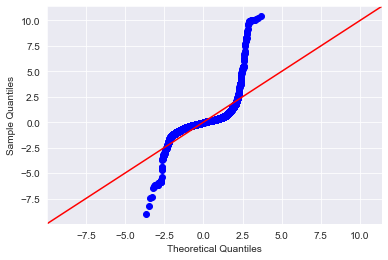

In [19]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

## Check Homoscedasticity Assumption

Check whether the model's errors are indeed homoscedastic or if they violate this principle and display heteroscedasticity.

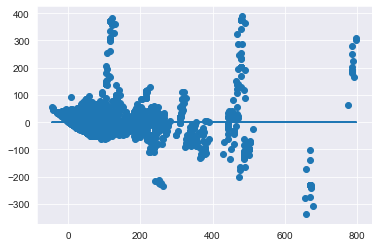

In [20]:
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

> **Comment:** This displays a fairly pronounced 'funnel' shape: errors appear to increase as the `list_price` increases. This doesn't bode well for our model. Subsetting the data to remove outliers and confining the model to this restricted domain may be necessary. A log transformation or something equivalent may also be appropriate.

## Make Additional Refinements

From here, make additional refinements to your model based on the above analysis. As you progress, continue to go back and check the assumptions for the updated model. Be sure to attempt at least two additional model refinements.

> **Comment:** Based on the above plots, it seems as though outliers are having a substantial impact on the model. As such, removing outliers may be appropriate. Investigating the impact of a log transformation is also worthwhile.

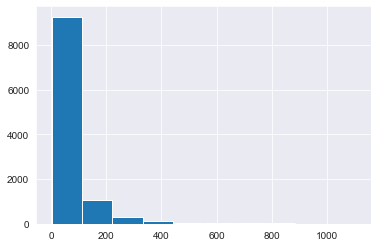

In [21]:
df.list_price.hist()

In [22]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, df.list_price.quantile(q=q)))

0.8 percentile: 90.986
0.81 percentile: 92.66216100000052
0.82 percentile: 97.5878
0.83 percentile: 101.898
0.84 percentile: 109.13971199999885
0.85 percentile: 110.352
0.86 percentile: 119.96492
0.87 percentile: 121.9878
0.88 percentile: 121.9878
0.89 percentile: 134.18779999999998
0.9 percentile: 143.952
0.91 percentile: 153.986
0.92 percentile: 170.7878
0.93 percentile: 182.9878
0.94 percentile: 198.7929
0.95 percentile: 220.03032999999942
0.96 percentile: 251.90543999999994
0.97 percentile: 292.7878
0.98 percentile: 359.88
0.99 percentile: 463.5878


In [23]:
orig_tot = len(df)
df = df[df.list_price < 450] # Subsetting to remove extreme outliers
print('Percent removed:', (orig_tot -len(df))/orig_tot)
df.list_price = df.list_price.map(np.log) # Applying a log transformation
train, test = train_test_split(df)

# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

Percent removed: 0.010487580496780129


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     457.3
Date:                Mon, 30 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:53:38   Log-Likelihood:                -4909.7
No. Observations:                8067   AIC:                             9931.
Df Residuals:                    8011   BIC:                         1.032e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            3.4008      0.013    254.158      0.000       3.375       3.427
piece_count                                          0.6322      0.010     62.797      0.000       0.612       0.652
num_reviews                                         -0.0211      0.008     -2.750      0.006      -0.036      -0.006
play_star_rating                                     0.1169      0.007     17.480      0.000       0.104       0.130
star_rating                                         -0.0570      0.008     -6.718      0.000      -0.074      -0.040
val_star_rating                                     -0.1264      0.008    -16.689      0.000      -0.141      -0.112
ages_10_14                                           0.1662      0.112      1.480      0.139      -0.054       0.386
ages_10_16                                           0.5089      0.044     11.471      0.000       0.422       0.596
ages_10_21                                           0.7583      0.041     18.609      0.000       0.678       0.838
ages_11_16                                           0.2171      0.068      3.203      0.001       0.084       0.350
ages_12_16                                          -0.1092      0.086     -1.277      0.202      -0.277       0.059
ages_14plus                                          0.2591      0.052      4.952      0.000       0.157       0.362
ages_2_5                                             0.5142      0.022     22.968      0.000       0.470       0.558
ages_5_12                                           -0.7453      0.032    -23.090      0.000      -0.809      -0.682
ages_6plus                                          -0.9030      0.067    -13.425      0.000      -1.035      -0.771
ages_6_12                                           -0.2010      0.019    -10.403      0.000      -0.239      -0.163
ages_7_12                                            0.0571      0.024      2.343      0.019       0.009       0.105
ages_7_14                                           -0.0682      0.021     -3.211      0.001      -0.110      -0.027
ages_8plus                                           0.5867      0.057     10.335      0.000       0.475       0.698
ages_8_12                                            0.2181      0.031      6.951      0.000       0.157       0.280
ages_8_14                                            0.2265      0.021     10.907      0.000       0.186       0.267
ages_9plus                                           0.1344      0.125      1.071      0.284      -0.112       0.380
ages_9_12                                            0.3884      0.074      5.252      0.000       0.243       0.533
theme_name_BOOST                         

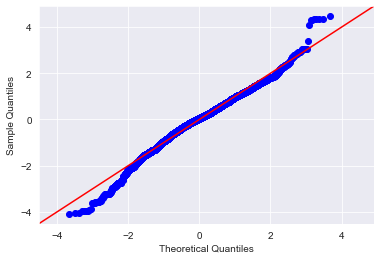

In [24]:
# Comment: This is much, much better!
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

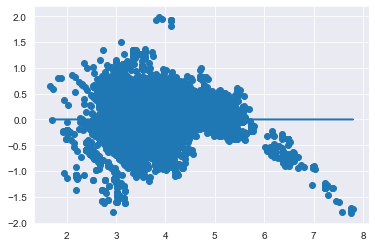

In [25]:
# Comment: There is still a clear underestimate now by the model as the log transformed 
# list price increases, but the model is much improved. Further subsetting is potentially warranted.
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

0.8 percentile: 4.447203233446613
0.81 percentile: 4.512971560274537
0.82 percentile: 4.542526402035123
0.83 percentile: 4.580752485605895
0.84 percentile: 4.640913706863106
0.85 percentile: 4.6985494117910225
0.86 percentile: 4.718373863481943
0.87 percentile: 4.787408405976297
0.88 percentile: 4.8039210397329235
0.89 percentile: 4.826327766567244
0.9 percentile: 4.89924031131419
0.91 percentile: 4.976713742220571
0.92 percentile: 5.0490223265009595
0.93 percentile: 5.140421850231899
0.94 percentile: 5.209419483952433
0.95 percentile: 5.292263579298989
0.96 percentile: 5.391752152536553
0.97 percentile: 5.528952783620542
0.98 percentile: 5.678340376637527
0.99 percentile: 5.873347331375852


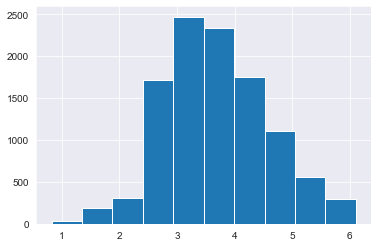

In [26]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, df.list_price.quantile(q=q)))

df.list_price.hist()

In [27]:
df = df[df.list_price <= 6]
train, test = train_test_split(df)

# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     452.9
Date:                Mon, 30 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:53:54   Log-Likelihood:                -4737.1
No. Observations:                8027   AIC:                             9586.
Df Residuals:                    7971   BIC:                             9978.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            3.4234      0.013    255.302      0.000       3.397       3.450
piece_count                                          0.7018      0.011     62.427      0.000       0.680       0.724
num_reviews                                         -0.0240      0.008     -3.062      0.002      -0.039      -0.009
play_star_rating                                     0.1146      0.007     17.175      0.000       0.101       0.128
star_rating                                         -0.0501      0.008     -5.962      0.000      -0.067      -0.034
val_star_rating                                     -0.1259      0.007    -16.807      0.000      -0.141      -0.111
ages_10_14                                           0.1770      0.125      1.416      0.157      -0.068       0.422
ages_10_16                                           0.4504      0.045      9.959      0.000       0.362       0.539
ages_10_21                                           0.7176      0.039     18.184      0.000       0.640       0.795
ages_11_16                                           0.0891      0.068      1.308      0.191      -0.044       0.223
ages_12_16                                          -0.5372      0.104     -5.141      0.000      -0.742      -0.332
ages_14plus                                          0.1467      0.053      2.766      0.006       0.043       0.251
ages_2_5                                             0.5144      0.022     23.602      0.000       0.472       0.557
ages_5_12                                           -0.7538      0.032    -23.553      0.000      -0.817      -0.691
ages_6plus                                          -0.9527      0.067    -14.217      0.000      -1.084      -0.821
ages_6_12                                           -0.2280      0.019    -11.799      0.000      -0.266      -0.190
ages_7_12                                            0.0589      0.024      2.454      0.014       0.012       0.106
ages_7_14                                           -0.0527      0.021     -2.544      0.011      -0.093      -0.012
ages_8plus                                           0.5521      0.054     10.296      0.000       0.447       0.657
ages_8_12                                            0.2028      0.030      6.684      0.000       0.143       0.262
ages_8_14                                            0.2254      0.021     10.924      0.000       0.185       0.266
ages_9plus                                           0.1481      0.134      1.104      0.270      -0.115       0.411
ages_9_12                                            0.3368      0.080      4.208      0.000       0.180       0.494
theme_name_BOOST                         

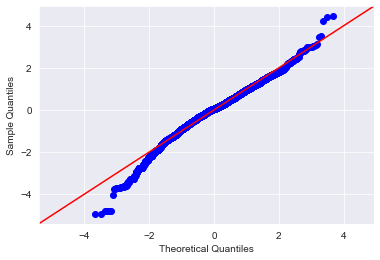

In [28]:
# Check the Normality Assumption
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [29]:
# Check the Homoscedasticity Assumption

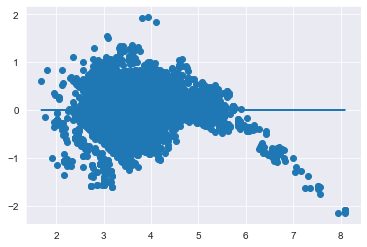

In [30]:
# Comment: No improvement observed
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

In [31]:
# An Alternative Approach: Building a Model From the Ground Up

In [32]:
x_cols = ['piece_count', 'country_US']

In [33]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     4434.
Date:                Mon, 30 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:54:05   Log-Likelihood:                -7436.4
No. Observations:                8027   AIC:                         1.488e+04
Df Residuals:                    8024   BIC:                         1.490e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.7329      0.007    527.630      0.000       3.719       3.747
piece_count     0.8069      0.009     93.500      0.000       0.790       0.824
country_US     -0.2618      0.028     -9.351      0.000      -0.317      -0.207
==============================================================================
Omnibus:                      498.509   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              739.010
Skew:                          -0.529   Prob(JB):                    3.36e-161
Kurtosis:                       4.044   Cond. No.                         4.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# Checking Assumptions for Simplified Model

In [35]:
# Check Normality Assumption

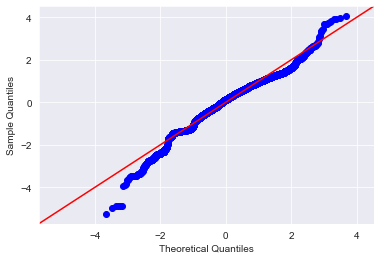

In [36]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [37]:
# Check Homoscedasticity Assumption

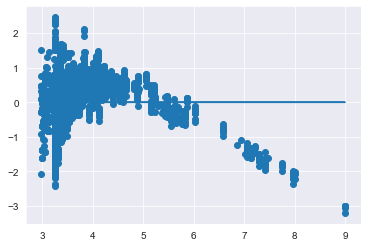

In [38]:
# Comment: Certainly not as strong a model, but with only 2 features, 
# over half the model performance was recovered.
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

## Summary

Well done! As you can see, regression can be a challenging task that requires you to make decisions along the way, try alternative approaches, and make ongoing refinements. These choices depend on the context and specific use cases. 